# Generating heatmap for the chemotaxonomy

### Import modules

In [1]:
from collections import defaultdict
from ast import literal_eval

import pandas as pd
import numpy as np
from tqdm import tqdm

# Import taxonomy
from utils import get_genus_and_family_info_for_plants

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 360
%matplotlib inline

In [3]:
tqdm.pandas()
pd.set_option('display.max_columns', None)

Load chemicals

In [2]:
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.zip',
    compression='zip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

In [3]:
plant_chemical_df.head(1)

,plant_curie,plant name,chemical_curie,chemical name,database,evidence
0,ncbitaxon:1000425,Pimpinella major,pubchem.compound:3527,"3-[(3,4-Dihydroxyphenyl)(hydroxy)methylidene]-...",coconut,Relation from COCONUT


In [6]:
len(plant_chemical_df.chemical_curie.unique())

71179

### Extract chemical classes

Load ClassyFire classes

In [7]:
classyfire_dict = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/classyfire_smiles.tsv.gz',
    sep='\t',
    compression='gzip',
    usecols=[
        'smiles',
        'class.name'
    ],
    index_col='smiles'
).to_dict()['class.name']

In [8]:
len(classyfire_dict)

64321

Load NPClassifier classes

In [9]:
np_classifier_dict = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/npclassifier_smiles.tsv.gz',
    sep='\t',
    compression='gzip',
    usecols=[
        'pubchem_openeye_can_smiles',
        'class_results'
    ],
    index_col='pubchem_openeye_can_smiles'
).to_dict()['class_results']

In [10]:
len(np_classifier_dict)

638605

Convert the SMILEs to PubChem ids

In [11]:
smiles_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/smiles.tsv.gz',
    sep='\t',
    compression='gzip',
)

In [12]:
pubchem_to_smiles = {}
all_smiles = set()

chemicals_in_plants = set(plant_chemical_df.chemical_curie.unique())

for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    if pubchem_id not in chemicals_in_plants:
        continue
    
    all_smiles.add(smiles)
    pubchem_to_smiles[pubchem_id] = smiles

smiles_to_pubchem = {
    smiles: pubchem
    for pubchem, smiles in pubchem_to_smiles.items()
}

100%|██████████| 71179/71179 [00:00<00:00, 429806.77it/s]


In [13]:
classyfire_dict = {
    smiles_to_pubchem[smile]: classes
    for smile, classes in classyfire_dict.items()
    if smile in smiles_to_pubchem
}
len(classyfire_dict)

1644

In [14]:
# Multiple classes associated with each chemical
np_classifier_dict = {
    smiles_to_pubchem[smile]: literal_eval(classes)
    for smile, classes in np_classifier_dict.items()
    if smile in smiles_to_pubchem and len(literal_eval(classes)) > 0
}
len(np_classifier_dict)

37889

### Compound class annotation

In [15]:
classyfire_annotated_plants = plant_chemical_df.copy(deep=True)
classyfire_annotated_plants['class'] = classyfire_annotated_plants['chemical_curie'].map(classyfire_dict)

In [16]:
# all plants
classyfire_annotated_plants.shape

(330655, 3)

In [17]:
classyfire_annotated_plants.dropna(subset=['class'], inplace=True)

In [18]:
classyfire_annotated_plants.shape

(11605, 3)

In [19]:
classyfire_annotated_plants['class'].value_counts()

Prenol lipids                               2909
Fatty Acyls                                 2649
Saturated hydrocarbons                      1564
Organooxygen compounds                      1499
Benzene and substituted derivatives          615
                                            ... 
Oxolanes                                       1
Organic phosphoric acids and derivatives       1
Organobromides                                 1
Organic sulfonic acids and derivatives         1
Organic sulfuric acids and derivatives         1
Name: class, Length: 82, dtype: int64

In [20]:
np_classifier_annotated_plants = plant_chemical_df.copy(deep=True)
np_classifier_annotated_plants['class'] = np_classifier_annotated_plants['chemical_curie'].map(np_classifier_dict)
np_classifier_annotated_plants = np_classifier_annotated_plants.explode('class')

In [21]:
# all plants
np_classifier_annotated_plants.shape

(358528, 3)

In [22]:
np_classifier_annotated_plants.dropna(subset=['class'], inplace=True)

In [23]:
np_classifier_annotated_plants.shape

(255626, 3)

In [24]:
np_classifier_annotated_plants['class'].value_counts()

Flavonols                         18856
Flavones                          12023
Cinnamic acids and derivatives     8380
Oleanane triterpenoids             6855
Simple phenolic acids              6469
                                  ...  
Cephamycins                           1
Other Docosanoids                     1
Isoaurones                            1
Griseofulvins                         1
Thia fatty acids                      1
Name: class, Length: 524, dtype: int64

### Create plant-class vectors
e.g., plant A: [class1, class2, class3, ...]

In [25]:
def create_np_classifier_vectors(df: pd.DataFrame):
    all_classes = set(df['class'].unique())
    plants = set(df['plant_curie'].unique())
    
    vector_data = []
    
    for plant_name in tqdm(plants, desc='Generated NP-Classifier vectors'):
        phytochem_df = df[df['plant_curie'] == plant_name]
        
        t = {
            'plant_name': plant_name,
        }
        
        for class_name in all_classes:
            temp = phytochem_df[phytochem_df['class'] == class_name]
            t[class_name] = len(temp['chemical_curie'].unique())
        
        vector_data.append(t)
            
    return pd.DataFrame(vector_data)
    

def create_classyfire_vectors(df: pd.DataFrame):
    all_classes = set(df['class'].unique())
    plants = set(df['plant_curie'].unique())
    
    vector_data = []
    
    for plant_name in tqdm(plants, desc='Generated Classifier vectors'):
        phytochem_df = df[df['plant_curie'] == plant_name]
        
        t = {
            'plant_name': plant_name,
        }
        
        for class_name in all_classes:
            temp = phytochem_df[phytochem_df['class'] == class_name]
            t[class_name] = len(temp['chemical_curie'].unique())
        
        vector_data.append(t)
            
    return pd.DataFrame(vector_data)

In [26]:
plant_to_npclassifier_vectors = create_np_classifier_vectors(np_classifier_annotated_plants)

Generated NP-Classifier vectors: 100%|██████████| 15906/15906 [45:27<00:00,  5.83it/s] 


In [27]:
plant_to_npclassifier_vectors.head(2)

,plant_name,Glucosinolates,Pseudoguaiane sesquiterpenoids,Apocarotenoids (β-),Lippifoliane sesquiterpenoids,Dialkylresorcinols,Segetane diterpenoids,Phenethylisoquinoline alkaloids,Mulinane diterpenoids,Purine alkaloids,Presilphiperfolane and Probotryane sesquiterpenoids,Himachalane sesquiterpenoids,Bufadienolides,"Carotenoids (C40, β-ε)",Limonoids,Usnic acid and derivatives,Shikimic acids and derivatives,Protoilludane sesquiterpenoids,Elemane sesquiterpenoids,Longifolane sesquiterpenoids,Cedrane and Isocedrane sesquiterpenoids,Thiazole alkaloids,Cyclitols,Longipinane sesquiterpenoids,Friedelane triterpenoids,Quinoline alkaloids,Merohemiterpenoids,Agarofuran sesquiterpenoids,Flavanones,Proanthocyanins,Oxazole alkaloids,Norpimarane and Norisopimarane diterpenoids,Rhamnolipids,Simple coumarins,Herbertane sesquiterpenoids,Meromonoterpenoids,Caryophyllane sesquiterpenoids,Paraliane diterpenoids,Dammarane and Protostane triterpenoids,Jatrophane diterpenoids,Aporphine alkaloids,Acorane sesquiterpenoids,Sinularane sesquiterpenoids,Polyene macrolides,Other Docosanoids,Furofuranoid lignans,Baccharane triterpenoids,Bergamotane sesquiterpenoids,Pregnane steroids,Halimane diterpenoids,Pyrazine and Piperazine alkaloids,Dunniane sesquiterpenoids,Premyrsinane diterpenoids,Indolizidine alkaloids,Terpenoid alkaloids,Cucurbitane triterpenoids,Pinguisane sesquiterpenoids,Thapsane sesquiterpenoids,Megastigmanes,Spongiane diterpenoids,Anthranillic acid derivatives,Oligomycins,Picrotoxane sesquiterpenoids,Fusidane triterpenoids,Gallotannins,Neohopane triterpenoids,Dimeric phloroglucinols,Oplopane sesquiterpenoids,Serratane triterpenoids,Abeotaxane diterpenoids,Acutumine alkaloids,Piperidine alkaloids,Furanoabietane diterpenoids,Cheilanthane sesterterpenoids,Corynanthe type,Thujane monoterpenoids,Fusicoccane diterpenoids,Hopane and Moretane triterpenoids,Valerane sesquiterpenoids,Androstane steroids,Anthraquinones and anthrones,p-Terphenyls,Macrotetrolides,Tetracyclic diterpenoids,Cholestane steroids,Trichothecane sesquiterpenoids,Bisabolane sesquiterpenoids,Labdane diterpenoids,Hirsutane sesquiterpenoids,Fernane and Arborinane triterpenoids,Chamigrane sesquiterpenoids,Caryolane sesquiterpenoids,Chromones,Pyridine alkaloids,Silphinane sesquiterpenoids,Phytofurans,Taxane diterpenoids,Miscellaneous polyketides,Stemona alkaloids,Aminosugars,Multiflorane triterpenoids,Cassane diterpenoids,Protopine alkaloids,Noreudesmane sesquiterpenoids,Isolactarane sesquiterpenoids,"Carotenoids (C40, β-κ)",Eremophilane sesquiterpenoids,Anthracyclines,Phenoxazine alkaloids,Unsaturated fatty acids,Glutinane triterpenoids,Ingenane diterpenoids,Cephalosporins,Other Eicosanoids,"Prenylated,geranylated phloroglucinols",pteridine alkaloids,Villanovane diterpenoids,Aplysiatoxins,Coumaronochromones,RiPPs-Cyanobactins,Oleanane triterpenoids,"Carotenoids (C40, ε-ε)",Anthocyanidins,Decalins with 2-pyrones,Sativane sesquiterpenoids,Branched fatty acids,Azaphilones,Phytane diterpenoids,Phloroglucinol-terpene hybrids,Yohimbine-like alkaloids,Isocomane sesquiterpenoids,Rhamnofolane diterpenoids,Macrolide lactones,Arylnaphthalene and aryltetralin lignans,Tigliane diterpenoids,Oxasqualenoids,Carbazole alkaloids,Noreremophilane sesquiterpenoids,Hydrocarbons,Humulane sesquiterpenoids,Quinazoline alkaloids,Secoeudesmane sesquiterpenoids,Copacamphane sesquiterpenoids,Drimane sesquiterpenoids,Gibberellins,Dipeptides,Fungal cyclic polyketides (Miscellaneous),"Indole diketopiperazine alkaloids (L-Trp, L-Ala)",Cyclobisabolane sesquiterpenoids,Bicyclohumulane sesquiterpenoids,4-pyrone derivatives,Colensane and Clerodane diterpenoids,Abeolupane triterpenoids,Guanacastane diterpenoids,Hydroxy-hydroperoxyeicosatetraenoic acids,Linear tetronates,Acyl phloroglucinols,Erythromycins,Ursane and Taraxastane triterpenoids,Cycloartane triterpenoids,Benzophenones,Nagilactone diterpenoids,Ergostane steroids,Bactoprenols,Ishwarane sesquiterpenoids,Depsidones,Simple amide alkaloids,3-acyl tetramic acids,Cepha

In [28]:
plant_to_classyfire_vectors = create_classyfire_vectors(classyfire_annotated_plants)

Generated Classifier vectors: 100%|██████████| 2978/2978 [01:17<00:00, 38.53it/s]


In [29]:
plant_to_classyfire_vectors.head(2)

,plant_name,Organic phosphoric acids and derivatives,Organic trisulfides,Benzopyrazoles,Pyridines and derivatives,Thioethers,Pyrrolidines,Coumarins and derivatives,Benzene and substituted derivatives,Organoiodides,Fatty Acyls,Quinolines and derivatives,Macrolactams,Oxanes,Organooxygen compounds,Organic sulfonic acids and derivatives,Pyrans,Organic disulfides,Prenol lipids,Polycyclic hydrocarbons,Isocoumarins and derivatives,Dithiins,Sulfinyl compounds,Azolidines,Glycerolipids,Sulfoxides,Cinnamaldehydes,Unsaturated hydrocarbons,Organobromides,Piperidines,Dithianes,Pyrrolines,Benzothiazoles,Thiols,Dihydrofurans,Oxazinanes,Pyrrolizidines,Allyl sulfur compounds,Isothiocyanates,Epoxides,Carboxylic acids and derivatives,Diazanaphthalenes,Azepanes,Keto acids and derivatives,Dioxanes,Naphthalenes,Indoles and derivatives,Cinnamic acids and derivatives,Azoles,Saturated hydrocarbons,Phenols,Diazines,Dithiolanes,Organic sulfuric acids and derivatives,Tropones,Tetrahydroisoquinolines,Tropane alkaloids,"3,4-dihydrocoumarins",Organonitrogen compounds,Phenol ethers,Sulfonyls,Hydroxy acids and derivatives,Imidazopyrimidines,Organic phosphines and derivatives,Organometalloid compounds,Benzoxazines,Pyrroles,Benzopyrans,Lactones,Thiophenes,Tetrahydrofurans,Tetralins,Tetrathianes,Heteroaromatic compounds,Benzimidazoles,Thiosulfinic acid esters,Oxolanes,Thioacetals,Furans,Organic dithiophosphoric acids and derivatives,Phenalenes,Trithianes,Sulfenyl compounds
0,ncbitaxon:714486,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ncbitaxon:1114741,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Collapsing plant species to plant families

In [30]:
genus_to_species, family_to_species = get_genus_and_family_info_for_plants(
    set(plant_chemical_df.plant_curie.unique())
)

order genus: 100%|██████████| 16884/16884 [00:00<00:00, 24880.05it/s]


# TODO: Plot the number of chemicals per family/genus

In [31]:
def plot_chemical_distribution(taxon_to_species):
    """Plot chemical distribution."""
    
    rows = []
    
    for taxon_name, species in tqdm(taxon_to_species.items()):
        unique_chemicals = plant_chemical_df[
            plant_chemical_df['plant_curie'].isin(species)
        ].chemical_curie.unique()
        
        rows.append({
            'taxon_group': taxon_name,
            'chemical_count': len(unique_chemicals),
        })
        
    df = pd.DataFrame(rows)
    df.set_index('taxon_group', inplace=True)
    
    g = sns.displot(
        data=df,
        x='chemical_count',
        stat="density",
        kde=True,
        common_norm=False,
        height=4,
        aspect=1.5,
        bins=1000,
        alpha=0.7,
    )

#     g.set(xlim=(-1, 10000))

    plt.show()

100%|██████████| 4711/4711 [00:40<00:00, 115.91it/s]


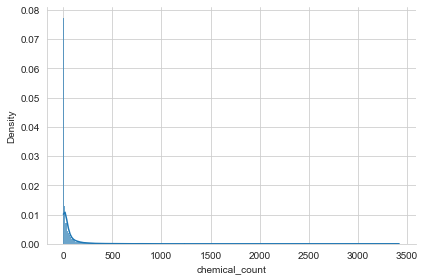

In [32]:
plot_chemical_distribution(genus_to_species)

100%|██████████| 504/504 [00:10<00:00, 47.25it/s] 


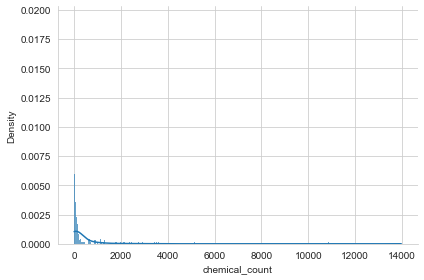

In [33]:
plot_chemical_distribution(family_to_species)

# TODO: Fixme and export without medicinal and non medicinal but all together

In [34]:
def collapse_to_family(df: pd.DataFrame, taxon_group):
    
    data = []
    skipped_empty = 0
    skipped_low = 0
    
    for family_curie, species in tqdm(taxon_group.items()):
        tmp_df = df[df['plant_name'].isin(species)]
        
        if tmp_df.empty:
            skipped_empty +=1
            continue
            
        tmp_df = tmp_df.drop(columns=['plant_name'])
        
        # Remove family/genus with chemical class less than 10
        if tmp_df.sum().sum() < 10:
            skipped_low +=1
            continue
        
        row_dict = tmp_df.sum().to_dict()
        row_dict['taxon'] = family_curie
        
        data.append(row_dict)

    print('Empty skipped empty:', skipped_empty)
    print('Empty skipped less than 10 chemicals:', skipped_low)
    
    df = pd.DataFrame(data)
    df.set_index('taxon', inplace=True)
    df.fillna(0, inplace=True)

    return df

        

In [35]:
classyfire_family_df = collapse_to_family(plant_to_classyfire_vectors, family_to_species)
classyfire_genus_df = collapse_to_family(plant_to_classyfire_vectors, genus_to_species)

classyfire_family_df.head(2)

100%|██████████| 504/504 [00:00<00:00, 776.03it/s]


Empty skipped empty: 235
Empty skipped less than 10 chemicals: 146


100%|██████████| 4711/4711 [00:04<00:00, 1170.22it/s]


Empty skipped empty: 3249
Empty skipped less than 10 chemicals: 1208


,Organic phosphoric acids and derivatives,Organic trisulfides,Benzopyrazoles,Pyridines and derivatives,Thioethers,Pyrrolidines,Coumarins and derivatives,Benzene and substituted derivatives,Organoiodides,Fatty Acyls,Quinolines and derivatives,Macrolactams,Oxanes,Organooxygen compounds,Organic sulfonic acids and derivatives,Pyrans,Organic disulfides,Prenol lipids,Polycyclic hydrocarbons,Isocoumarins and derivatives,Dithiins,Sulfinyl compounds,Azolidines,Glycerolipids,Sulfoxides,Cinnamaldehydes,Unsaturated hydrocarbons,Organobromides,Piperidines,Dithianes,Pyrrolines,Benzothiazoles,Thiols,Dihydrofurans,Oxazinanes,Pyrrolizidines,Allyl sulfur compounds,Isothiocyanates,Epoxides,Carboxylic acids and derivatives,Diazanaphthalenes,Azepanes,Keto acids and derivatives,Dioxanes,Naphthalenes,Indoles and derivatives,Cinnamic acids and derivatives,Azoles,Saturated hydrocarbons,Phenols,Diazines,Dithiolanes,Organic sulfuric acids and derivatives,Tropones,Tetrahydroisoquinolines,Tropane alkaloids,"3,4-dihydrocoumarins",Organonitrogen compounds,Phenol ethers,Sulfonyls,Hydroxy acids and derivatives,Imidazopyrimidines,Organic phosphines and derivatives,Organometalloid compounds,Benzoxazines,Pyrroles,Benzopyrans,Lactones,Thiophenes,Tetrahydrofurans,Tetralins,Tetrathianes,Heteroaromatic compounds,Benzimidazoles,Thiosulfinic acid esters,Oxolanes,Thioacetals,Furans,Organic dithiophosphoric acids and derivatives,Phenalenes,Trithianes,Sulfenyl compounds
taxon,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ncbitaxon:3568,0,0,0,0,0,1,0,2,0,8,0,0,0,4,0,0,0,3,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ncbitaxon:69450,0,0,0,0,0,0,0,0,0,4,0,0,0,9,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
np_classyfire_family_df = collapse_to_family(plant_to_npclassifier_vectors, family_to_species)
np_classyfire_genus_df = collapse_to_family(plant_to_npclassifier_vectors, genus_to_species)

100%|██████████| 504/504 [00:01<00:00, 301.19it/s]


Empty skipped empty: 27
Empty skipped less than 10 chemicals: 111


100%|██████████| 4711/4711 [00:11<00:00, 402.79it/s]


Empty skipped empty: 407
Empty skipped less than 10 chemicals: 1760


In [37]:
classyfire_family_df.to_csv(
    's3://enveda-datascience/daniel_domingo/chemical_classification/classyfire_family_vector.tsv', sep='\t'
)
classyfire_genus_df.to_csv(
    's3://enveda-datascience/daniel_domingo/chemical_classification/classyfire_genus_vector.tsv', sep='\t'
)

In [38]:
np_classyfire_family_df.to_csv(
    's3://enveda-datascience/daniel_domingo/chemical_classification/np_classifier_family_vector.tsv', sep='\t'
)
np_classyfire_genus_df.to_csv(
    's3://enveda-datascience/daniel_domingo/chemical_classification/np_classifier_genus_vector.tsv', sep='\t'
)

### Export dataframes as a relative percentage

In [39]:
def convert_to_percent(df: pd.DataFrame):
    """Convert counts to percentages for each row."""
    res = df.div(df.sum(axis=1), axis=0)
    
    a = res.sum(axis=1) 
    assert np.isclose(a.values, [1]*a.shape[0]).all(), 'Not all rows sum to 1'
    return res

In [40]:
classyfire_genus_df = convert_to_percent(classyfire_genus_df)
np_classyfire_genus_df = convert_to_percent(np_classyfire_genus_df)

In [41]:
classyfire_family_df = convert_to_percent(classyfire_family_df)
classyfire_family_df.head(2)

,Organic phosphoric acids and derivatives,Organic trisulfides,Benzopyrazoles,Pyridines and derivatives,Thioethers,Pyrrolidines,Coumarins and derivatives,Benzene and substituted derivatives,Organoiodides,Fatty Acyls,Quinolines and derivatives,Macrolactams,Oxanes,Organooxygen compounds,Organic sulfonic acids and derivatives,Pyrans,Organic disulfides,Prenol lipids,Polycyclic hydrocarbons,Isocoumarins and derivatives,Dithiins,Sulfinyl compounds,Azolidines,Glycerolipids,Sulfoxides,Cinnamaldehydes,Unsaturated hydrocarbons,Organobromides,Piperidines,Dithianes,Pyrrolines,Benzothiazoles,Thiols,Dihydrofurans,Oxazinanes,Pyrrolizidines,Allyl sulfur compounds,Isothiocyanates,Epoxides,Carboxylic acids and derivatives,Diazanaphthalenes,Azepanes,Keto acids and derivatives,Dioxanes,Naphthalenes,Indoles and derivatives,Cinnamic acids and derivatives,Azoles,Saturated hydrocarbons,Phenols,Diazines,Dithiolanes,Organic sulfuric acids and derivatives,Tropones,Tetrahydroisoquinolines,Tropane alkaloids,"3,4-dihydrocoumarins",Organonitrogen compounds,Phenol ethers,Sulfonyls,Hydroxy acids and derivatives,Imidazopyrimidines,Organic phosphines and derivatives,Organometalloid compounds,Benzoxazines,Pyrroles,Benzopyrans,Lactones,Thiophenes,Tetrahydrofurans,Tetralins,Tetrathianes,Heteroaromatic compounds,Benzimidazoles,Thiosulfinic acid esters,Oxolanes,Thioacetals,Furans,Organic dithiophosphoric acids and derivatives,Phenalenes,Trithianes,Sulfenyl compounds
taxon,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ncbitaxon:3568,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.074074,0.0,0.296296,0.0,0.0,0.0,0.148148,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.037037,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074074,0.0,0.0,0.0,0.0,0.0,0.148148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ncbitaxon:69450,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.065574,0.0,0.0,0.0,0.147541,0.0,0.0,0.0,0.262295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.524590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
np_classyfire_family_df = convert_to_percent(np_classyfire_family_df)
np_classyfire_family_df.head(2)

,Glucosinolates,Pseudoguaiane sesquiterpenoids,Apocarotenoids (β-),Lippifoliane sesquiterpenoids,Dialkylresorcinols,Segetane diterpenoids,Phenethylisoquinoline alkaloids,Mulinane diterpenoids,Purine alkaloids,Presilphiperfolane and Probotryane sesquiterpenoids,Himachalane sesquiterpenoids,Bufadienolides,"Carotenoids (C40, β-ε)",Limonoids,Usnic acid and derivatives,Shikimic acids and derivatives,Protoilludane sesquiterpenoids,Elemane sesquiterpenoids,Longifolane sesquiterpenoids,Cedrane and Isocedrane sesquiterpenoids,Thiazole alkaloids,Cyclitols,Longipinane sesquiterpenoids,Friedelane triterpenoids,Quinoline alkaloids,Merohemiterpenoids,Agarofuran sesquiterpenoids,Flavanones,Proanthocyanins,Oxazole alkaloids,Norpimarane and Norisopimarane diterpenoids,Rhamnolipids,Simple coumarins,Herbertane sesquiterpenoids,Meromonoterpenoids,Caryophyllane sesquiterpenoids,Paraliane diterpenoids,Dammarane and Protostane triterpenoids,Jatrophane diterpenoids,Aporphine alkaloids,Acorane sesquiterpenoids,Sinularane sesquiterpenoids,Polyene macrolides,Other Docosanoids,Furofuranoid lignans,Baccharane triterpenoids,Bergamotane sesquiterpenoids,Pregnane steroids,Halimane diterpenoids,Pyrazine and Piperazine alkaloids,Dunniane sesquiterpenoids,Premyrsinane diterpenoids,Indolizidine alkaloids,Terpenoid alkaloids,Cucurbitane triterpenoids,Pinguisane sesquiterpenoids,Thapsane sesquiterpenoids,Megastigmanes,Spongiane diterpenoids,Anthranillic acid derivatives,Oligomycins,Picrotoxane sesquiterpenoids,Fusidane triterpenoids,Gallotannins,Neohopane triterpenoids,Dimeric phloroglucinols,Oplopane sesquiterpenoids,Serratane triterpenoids,Abeotaxane diterpenoids,Acutumine alkaloids,Piperidine alkaloids,Furanoabietane diterpenoids,Cheilanthane sesterterpenoids,Corynanthe type,Thujane monoterpenoids,Fusicoccane diterpenoids,Hopane and Moretane triterpenoids,Valerane sesquiterpenoids,Androstane steroids,Anthraquinones and anthrones,p-Terphenyls,Macrotetrolides,Tetracyclic diterpenoids,Cholestane steroids,Trichothecane sesquiterpenoids,Bisabolane sesquiterpenoids,Labdane diterpenoids,Hirsutane sesquiterpenoids,Fernane and Arborinane triterpenoids,Chamigrane sesquiterpenoids,Caryolane sesquiterpenoids,Chromones,Pyridine alkaloids,Silphinane sesquiterpenoids,Phytofurans,Taxane diterpenoids,Miscellaneous polyketides,Stemona alkaloids,Aminosugars,Multiflorane triterpenoids,Cassane diterpenoids,Protopine alkaloids,Noreudesmane sesquiterpenoids,Isolactarane sesquiterpenoids,"Carotenoids (C40, β-κ)",Eremophilane sesquiterpenoids,Anthracyclines,Phenoxazine alkaloids,Unsaturated fatty acids,Glutinane triterpenoids,Ingenane diterpenoids,Cephalosporins,Other Eicosanoids,"Prenylated,geranylated phloroglucinols",pteridine alkaloids,Villanovane diterpenoids,Aplysiatoxins,Coumaronochromones,RiPPs-Cyanobactins,Oleanane triterpenoids,"Carotenoids (C40, ε-ε)",Anthocyanidins,Decalins with 2-pyrones,Sativane sesquiterpenoids,Branched fatty acids,Azaphilones,Phytane diterpenoids,Phloroglucinol-terpene hybrids,Yohimbine-like alkaloids,Isocomane sesquiterpenoids,Rhamnofolane diterpenoids,Macrolide lactones,Arylnaphthalene and aryltetralin lignans,Tigliane diterpenoids,Oxasqualenoids,Carbazole alkaloids,Noreremophilane sesquiterpenoids,Hydrocarbons,Humulane sesquiterpenoids,Quinazoline alkaloids,Secoeudesmane sesquiterpenoids,Copacamphane sesquiterpenoids,Drimane sesquiterpenoids,Gibberellins,Dipeptides,Fungal cyclic polyketides (Miscellaneous),"Indole diketopiperazine alkaloids (L-Trp, L-Ala)",Cyclobisabolane sesquiterpenoids,Bicyclohumulane sesquiterpenoids,4-pyrone derivatives,Colensane and Clerodane diterpenoids,Abeolupane triterpenoids,Guanacastane diterpenoids,Hydroxy-hydroperoxyeicosatetraenoic acids,Linear tetronates,Acyl phloroglucinols,Erythromycins,Ursane and Taraxastane triterpenoids,Cycloartane triterpenoids,Benzophenones,Nagilactone diterpenoids,Ergostane steroids,Bactoprenols,Ishwarane sesquiterpenoids,Depsidones,Simple amide alkaloids,3-acyl tetramic acids,Cephamycins,Glyc

In [43]:
classyfire_family_df.to_csv(
    's3://enveda-datascience/daniel_domingo/chemical_classification/classyfire_family_percentage_vector.tsv', sep='\t'
)
classyfire_genus_df.to_csv(
    's3://enveda-datascience/daniel_domingo/chemical_classification/classyfire_genus_percentage_vector.tsv', sep='\t'
)

In [44]:
np_classyfire_family_df.to_csv(
    's3://enveda-datascience/daniel_domingo/chemical_classification/np_classifier_family_percentage_vector.tsv', sep='\t'
)
np_classyfire_genus_df.to_csv(
    's3://enveda-datascience/daniel_domingo/chemical_classification/np_classifier_genus_percentage_vector.tsv', sep='\t'
)